<a href="https://colab.research.google.com/github/Alirs2002/fashion_GAN/blob/main/fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds

In [3]:
data_set = tfds.load("fashion_mnist",split= "train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8TPSBP/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8TPSBP/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
def scale_images(data):
  img = data["image"]
  img = img/255
  return img

In [5]:
#data_set = data_set.as_numpy_iterator()

data_set= data_set.map(scale_images)
data_set = data_set.cache()
data_set = data_set.shuffle(60000)
data_set = data_set.batch(128)
data_set = data_set.prefetch(64)

In [6]:
data_set.as_numpy_iterator().next().shape

(128, 28, 28, 1)

now lets create our generator and the discriminator models

In [7]:
from tensorflow.keras import Sequential,Model

In [8]:
def create_generator():
  model = Sequential()

  model.add(tf.keras.layers.Dense(7*7*128,input_dim = 128))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Reshape((7,7,128)))

  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(128,4,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(128,4,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Conv2D(1,4,padding="same",activation="sigmoid"))

  return model



bellow is a function for creating discriminator

In [9]:
def create_discriminator():

  model = Sequential()

  model.add(tf.keras.layers.Input(shape=(28,28,1)))
  model.add(tf.keras.layers.Conv2D(32,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Conv2D(64,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Conv2D(128,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Conv2D(256,5,padding="same"))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.4))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

  return model

In [10]:
generator = create_generator()
discriminator = create_discriminator()

now lets see a summary of the two parts of out GAN networks

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)      

### now its time to create out training loop

In [13]:
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

g_loss = tf.keras.losses.BinaryCrossentropy()
d_loss = tf.keras.losses.BinaryCrossentropy()
import tensorflow

In [14]:
class GAN_network(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)

    self.generator = generator
    self.discriminator = discriminator

  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    super().compile(*args,**kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self,batch):

    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images,training=True)
      yhat_fake = self.discriminator(fake_images,training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)

      y_real_fake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis = 0)

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_real_fake += tf.concat([noise_real,noise_fake],axis=0)

      total_d_loss = self.d_loss(y_real_fake,yhat_realfake)

    d_gradient = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradient,self.discriminator.trainable_variables))


    with tf.GradientTape() as g_tape:

      generated_images = self.generator(tf.random.normal((128,128,1)),training=True)
      predicted_labels = self.discriminator(generated_images,training=False)

      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

    g_gradient = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradient,self.generator.trainable_variables))

    return {"g_loss ": total_g_loss , "d_loss ": total_d_loss}






In [15]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os

In [19]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            #img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))


In [20]:
fashion_gan = GAN_network(generator,discriminator)
fashion_gan.compile(g_opt,d_opt,g_loss,d_loss)

In [22]:
hist = fashion_gan.fit(data_set,epochs=40,callbacks=[ModelMonitor()])

Epoch 1/40
  6/469 [..............................] - ETA: 1:57 - g_loss : 0.6814 - d_loss : 0.7071

469/469 [==============================] - 121s 258ms/step - g_loss : 0.6736 - d_loss : 0.6934
Epoch 2/40
469/469 [==============================] - 121s 259ms/step - g_loss : 1.3150 - d_loss : 0.5249
Epoch 3/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.7078 - d_loss : 0.2732
Epoch 4/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.7980 - d_loss : 0.2702
Epoch 5/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.8120 - d_loss : 0.2685
Epoch 6/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.8089 - d_loss : 0.2686
Epoch 7/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.8179 - d_loss : 0.2679
Epoch 8/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.8269 - d_loss : 0.2676
Epoch 9/40
469/469 [==============================] - 121s 258ms/step - g_loss : 2.8455 - d_loss : 0.2672
Epoch 10/40
469/469 [==============================] - 12

1/1 [==============================] - 0s 447ms/step


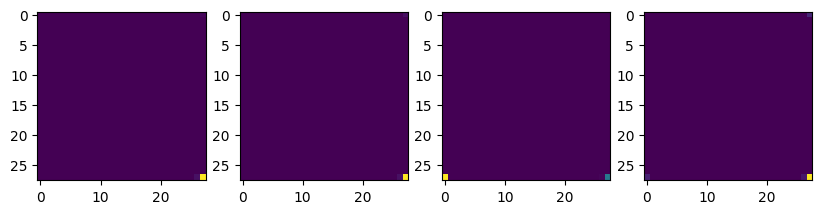

In [23]:
imgs = generator.predict(tf.random.normal((4,128,1)))

fig,ax = plt.subplots(ncols=4,figsize=(10,10))
for r in range(4):
  ax[r].imshow(imgs[r])

as you can see even after one hour we can see the performance is poor
so i use a pretrained weights for this network

In [29]:
generator.load_weights("/content/generatormodel.h5")

ValueError: axes don't match array